In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
data_dir = '/kaggle/input/digits/training-d'
csv_file = '/kaggle/input/digits/training-d.csv'
data_df = pd.read_csv(csv_file)

In [4]:
# Split the dataset into training, validation, and test sets
train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [5]:
# Load and preprocess the images and labels
def load_and_preprocess_data(df):
    images = []
    labels = []

    for index, row in df.iterrows():
        image_path = os.path.join(data_dir, row['filename'])
        image = load_img(image_path, target_size=(180, 180))
        image = img_to_array(image) / 255.0  # Normalize pixel values
        label = row['digit']
        
        images.append(image)
        labels.append(label)
    
    return np.array(images), np.array(labels)

X_train, y_train = load_and_preprocess_data(train_df)
X_val, y_val = load_and_preprocess_data(val_df)
X_test, y_test = load_and_preprocess_data(test_df)

In [6]:
# Load a pre-trained DenseNet model (excluding the top layers) from the local file
weights_path = '/kaggle/input/densenet/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = DenseNet121(weights=weights_path, include_top=False)

In [7]:
# Add custom top layers for classification
num_classes = 10
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [8]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [9]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
# Train the model
num_epochs = 10

history = model.fit(
    X_train,
    y_train,
    epochs=num_epochs,
    validation_data=(X_val, y_val)
)

Epoch 1/10
219/219 [==============================] - 31s 79ms/step - loss: 0.4042 - accuracy: 0.8728 - val_loss: 0.1869 - val_accuracy: 0.9376
Epoch 2/10
219/219 [==============================] - 11s 52ms/step - loss: 0.1447 - accuracy: 0.9550 - val_loss: 0.1547 - val_accuracy: 0.9439
Epoch 3/10
219/219 [==============================] - 12s 55ms/step - loss: 0.0988 - accuracy: 0.9691 - val_loss: 0.1624 - val_accuracy: 0.9490
Epoch 4/10
219/219 [==============================] - 12s 54ms/step - loss: 0.0871 - accuracy: 0.9731 - val_loss: 0.1261 - val_accuracy: 0.9582
Epoch 5/10
219/219 [==============================] - 11s 52ms/step - loss: 0.0679 - accuracy: 0.9781 - val_loss: 0.0979 - val_accuracy: 0.9639
Epoch 6/10
219/219 [==============================] - 12s 56ms/step - loss: 0.0615 - accuracy: 0.9751 - val_loss: 0.1590 - val_accuracy: 0.9462
Epoch 7/10
219/219 [==============================] - 12s 54ms/step - loss: 0.0581 - accuracy: 0.9798 - val_loss: 0.1058 - val_accuracy:

In [11]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

69/69 [==============================] - 4s 59ms/step - loss: 0.1105 - accuracy: 0.9716
Test Accuracy: 97.16%


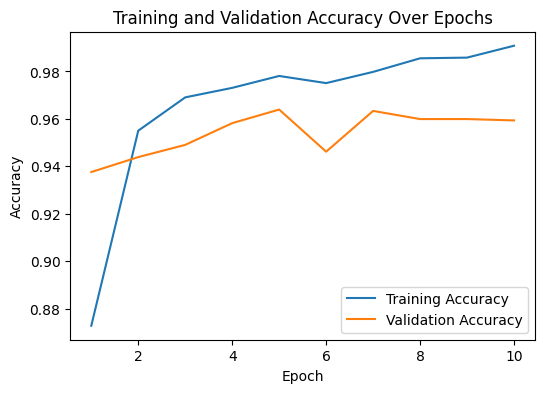

In [12]:
# Extract training and validation accuracy values from the history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create a graph to visualize the training and validation accuracy
plt.figure(figsize=(6, 4))
plt.plot(range(1, num_epochs + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

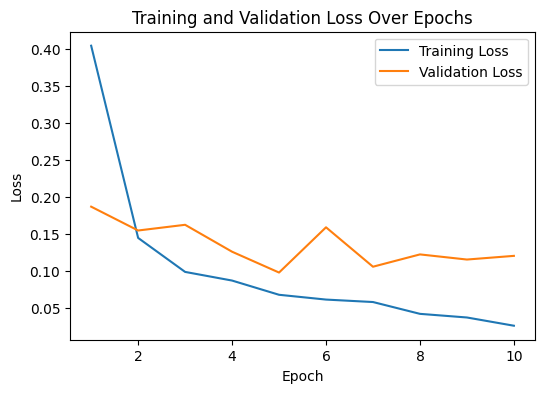

In [13]:
# Extract the training and validation loss values from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a graph to visualize the training and validation loss
plt.figure(figsize=(6, 4))
plt.plot(range(1, num_epochs + 1), train_loss, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

69/69 [==============================] - 5s 38ms/step


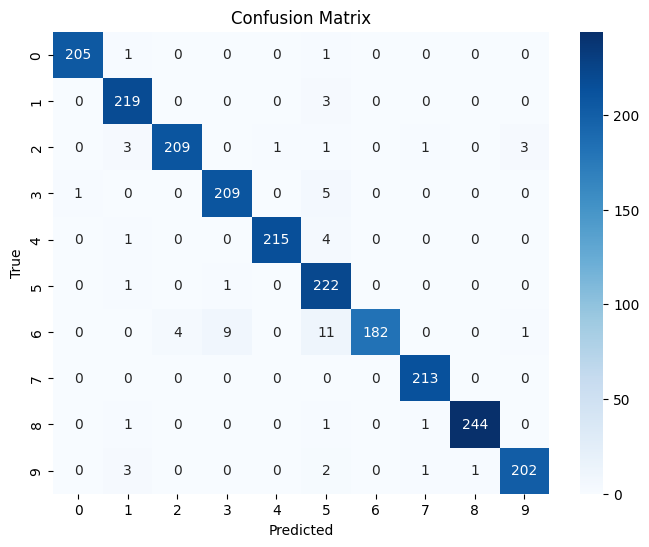

In [14]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [15]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp

In [16]:
y_test_one_hot = label_binarize(y_test, classes=np.arange(num_classes))

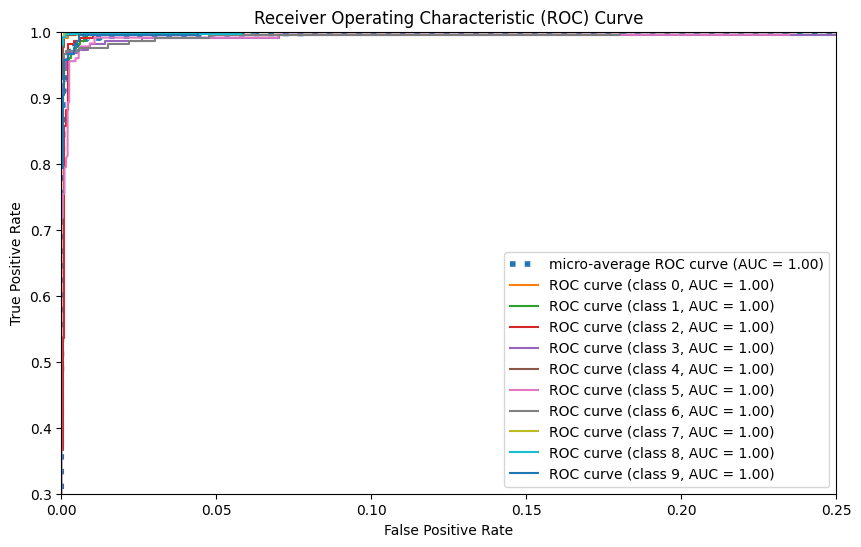

In [17]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_one_hot.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr["micro"], tpr["micro"], label=f'micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})', linestyle=':', linewidth=4)

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}, AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 0.25])
plt.ylim([0.3, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_labels)

# Calculate precision and recall for each class
precision_per_class = precision_score(y_test, y_pred_labels, average=None)
recall_per_class = recall_score(y_test, y_pred_labels, average=None)

# Calculate macro-averaged precision and recall
macro_precision = precision_score(y_test, y_pred_labels, average='macro')
macro_recall = recall_score(y_test, y_pred_labels, average='macro')

# Print the results
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Macro-averaged Precision: {macro_precision*100:.2f}%")
print(f"Macro-averaged Recall: {macro_recall*100:.2f}%")

Accuracy: 97.16%
Macro-averaged Precision: 97.33%
Macro-averaged Recall: 97.10%


In [19]:
import random

# Generate a random index within the range of the test dataset
random_index = random.randint(0, len(X_test) - 1)

# Get the image and label at the random index
random_image = X_test[random_index]
random_label = y_test[random_index]

# Reshape the image to match the model's input shape
random_image = random_image.reshape(1, 180, 180, 3)

# Make a prediction using the model
prediction = model.predict(random_image)

# Convert the prediction to a class label
predicted_class = np.argmax(prediction)

print(f"Randomly selected image: {random_index}")
print(f"Actual label: {random_label}")
print(f"Predicted label: {predicted_class}")

1/1 [==============================] - 1s 910ms/step
Randomly selected image: 438
Actual label: 1
Predicted label: 1
